# Практическое ДЗ 3

# Задача 1. Compressed Sensing (50 баллов)

In [1]:
# Если вы на windows - скачивайте сами
!mkdir data
!wget https://github.com/DimaLishudi/fmatcomp/raw/main/tune.wav      -O data/tune.wav
!wget https://github.com/DimaLishudi/fmatcomp/raw/main/crater.png    -O data/crater.png
!wget https://github.com/DimaLishudi/fmatcomp/raw/main/cameraman.tif -O data/cameraman.tif

--2023-04-06 22:35:30--  https://github.com/DimaLishudi/fmatcomp/raw/main/tune.wav
Распознаётся github.com (github.com)… 140.82.121.3
Подключение к github.com (github.com)|140.82.121.3|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://raw.githubusercontent.com/DimaLishudi/fmatcomp/main/tune.wav [переход]
--2023-04-06 22:35:30--  https://raw.githubusercontent.com/DimaLishudi/fmatcomp/main/tune.wav
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 176458 (172K) [audio/wav]
Сохранение в: «data/tune.wav»

data/tune.wav       100%[===================>] 172,32K  --.-KB/s    за 0,1s    

2023-04-06 22:35:30 (1,56 MB/s) - «data/tune.wav» сохранён [176458/176458]

--2023-04-06 22:35:31--  https://github.com/Di

В этом задании мы реализуем метод Compressed Sensing для восстановления сигнала, в котором большая часть значений отсутствует. Можете прочитать подробнее в [википедии](https://en.wikipedia.org/wiki/Compressed_sensing) или посмотреть серию коротких видео [1,](https://www.youtube.com/watch?v=EOYaKcjFa3o&list=PLVnEmTOBCgy0QFxU5kKNFOy1CIwCieSDl) [2,](https://www.youtube.com/watch?v=SbU1pahbbkc) [3.](https://www.youtube.com/watch?v=inr-nGnVc0k)

**Обратите внимание:** <font color='red'>во всех пунктах всех задач запрещается использовать циклы.</font>

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.sparse as sparse
import scipy.sparse.linalg as spla

from IPython import display
from scipy.io.wavfile import read as read_audio

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

### a. (25 баллов) Дискретное косинусное преобразование

**Замечание:** Если вы не полностью выполните следующие два пункта, то это не повлияет на выполнение оставшейся части задачи. В следующих разделах нужно использовать библиотечные `scipy.fft.dct` и `scipy.fft.idct` с параметрами `type=2`, `norm="ortho"`. **В этом разделе их использовать запрещено!**

In [3]:
from scipy.fft import dct, idct

Для работы с аудиодорожками зачастую используют дискретное преобразование Фурье (ДПФ) для перехода от времени к частотам. Однако нам будет удобнее работать с его вещественнозначным аналогом - дискретным косинусным преобразованием (ДКП). Именно это преобразование лежит в основе алгоритма сжатия JPEG.

В этом задании нужно будет реализовать ДКП типа II, переводящее вектор $x \in \mathbb{R}^n$ в вектор $s' \in \mathbb{R}^n$ по правилу:

$$
    s_p = 2\sum_{q=0}^{n-1} x_q \cos \left(\frac{\pi}{2n}p(2q + 1)\right)
$$

То есть:

$$
    s = \hat{D}_n x
$$

Где матрица ДКП $\hat{D}_n$ определяется как:

\
$$
    \hat{D}_n = 2\begin{bmatrix}
        1 & 1 & 1 & \ldots & 1\\
        \cos \left(\frac{\pi}{2n} \cdot 1\right) & \cos \left(\frac{\pi}{2n} \cdot 3\right) & \cos \left(\frac{\pi}{2n} \cdot 5\right) & \ldots & \cos \left(\frac{\pi}{2n} \cdot (2n-1)\right)\\
        \cos \left(2\frac{\pi}{2n} \cdot 1\right) & \cos \left(2\frac{\pi}{2n} \cdot 3\right) & \cos \left(2\frac{\pi}{2n} \cdot 5\right) & \ldots & \cos \left(2\frac{\pi}{2n} \cdot (2n-1)\right)\\
        \vdots & \vdots & \vdots & \ddots & \vdots\\
        \cos \left((n-1)\frac{\pi}{2n} \cdot 1\right) & \cos \left((n-1)\frac{\pi}{2n} \cdot 3\right) & \cos \left((n-1)\frac{\pi}{2n} \cdot 5\right) & \ldots & \cos \left((n-1)\frac{\pi}{2n} \cdot (2n-1)\right)\\
    \end{bmatrix}
$$
\
Несмотря на то, что такое преобразование легко выражается матричным умножением, его сложность составляет $O(n^2)$. Тем не менее, используя БПФ, это преобразование можно выполнить за $O(n \log n)$.


1. **(9 баллов)** Покажите, что ДКП для вектора длины $n$ выражается с помощью сдвинутого БПФ для вектора $\hat{x} \in \mathbb{R}^{2n}$:

\
$$
\hat{x} = \begin{bmatrix}
        x_0\\
        x_1\\
        \vdots\\
        x_{n-1}\\
        x_{n-1}\\
        x_{n-2}\\
        \vdots\\
        x_0
    \end{bmatrix}\\
$$

\begin{align*}
    s_p = \exp\left(\frac{-\pi i}{2n}p\right)&\sum_{q=0}^{2n-1} \hat{x}_q \exp\left(\frac{-2\pi i}{2n}pq\right)
\end{align*}

**Ваше решение:**

$\displaystyle s_p = \exp\left(\frac{-\pi i}{2n}p\right) \sum_{q=0}^{2n-1}\hat{x}_q \exp\left(\frac{-2\pi i}{2n}pq\right)$
$=\sum_{q=0}^{2n-1}\hat{x}_q \exp\left(\frac{-\pi i}{2n}p + \frac{-2\pi i}{2n}pq\right) =$
$\sum_{q=0}^{2n-1}\hat{x}_q \exp\left(\frac{-\pi i}{2n}p(1 + 2q)\right) =$
$\sum_{q=0}^{2n-1}\hat{x}_q (\cos\left(\frac{-\pi}{2n}p(1 + 2q)\right) + i\sin\left(\frac{-\pi}{2n}p(1 + 2q)\right)) =$

**В действительных числах:** $\cos \frac{2\pi p (n-q)}{n} = \cos \frac{2\pi p q}{n}, \sin \frac{2\pi p (n-q)}{n} = - \sin \frac{2\pi p q}{n}$ 

$=2\sum_{q=0}^{n-1}\hat{x}_q (\cos\left(\frac{-\pi}{2n}p(1 + 2q)\right))$

#### Нам будет удобнее работать с нормированным ДКП (т.е. ортогональной матрицей), поэтому выходы $s_p$ поделим на нормы соответствующих строк. Несложно проверить, что столбцы (и строки) матрицы $\hat D_n$ ортогональны. Норма первой строки равна $2\sqrt{n}$, норма остальных -- $\sqrt{2n}$. Поделив строки $\hat{D}_n$ на соответствующие нормы, получим матрицу ортогонального ДКП II типа $D_n$.

Далее везде работаем с ортонормированным ДКП II типа

2. **(16 баллов)** С помощью `np.fft.fft` реализуйте нормированное ДКП II типа (соответствующее умножению $D_n x$), а также обратное преобразование (соответствующее умножению $D_n^Tx$).

Аналогично `np.fft.fft`, ваша реализация должна уметь работать с массивами произвольной размерности $d$ и выполнять ДКП вдоль произвольной оси *axis* от $0$ до $d-1$. Иными словами, можно считать что на вход подаётся массив векторов, где все размерности, кроме одной, отвечают за номер вектора в массиве, а оставшаяся размерность -- за координату самого вектора. Вам может пригодиться [`np.take`](https://numpy.org/doc/stable/reference/generated/numpy.take.html), а также [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html). Многие функции numpy поддерживают выполнение вдоль произвольной оси *axis*, пользуйтесь этим!

За решение лишь для одномерных массивов будет выставлен лишь частичный балл.

In [4]:
def orth_dct(x: np.ndarray, axis: int=0):
    doublex = np.concatenate([x, np.flip(x, axis=axis)], axis=axis)
    new_shape = list(doublex.shape)
    n2 = new_shape[axis]
    fftdoublex = np.fft.fft(doublex, axis=axis)
    coefs = np.exp(np.arange(n2) * (-np.pi * 1j)/(n2)) / np.sqrt(n2)
    coefs[0] /= np.sqrt(2)
    order = np.arange(len(new_shape))
    order[-1], order[axis] = order[axis], order[-1]
    fftdoublex = np.transpose(fftdoublex, order)
    res = coefs * fftdoublex 
    res = np.transpose(res, order)
    res = np.take(res, np.arange(n2//2), axis=axis)

#     correct = dct(x, axis=axis, norm="ortho")
#     print(np.allclose(correct, res.real))
    return res.real


Если вы всё сделали правильно, то ваша реализация должна совпадать с `scipy.fft.dct(x, type=2, norm=norm="ortho", axis=...)`. Проверим:

In [5]:
noise = np.random.randn(10)
assert np.allclose(orth_dct(noise, axis=0), dct(noise, norm="ortho")), "Incorrect DCT for 1d array"

noise = np.random.randn(4, 8, 16, 32)
for axis in range(noise.ndim):
    assert np.allclose(orth_dct(noise, axis=axis), dct(noise, axis=axis, norm="ortho")), f"Incorrect DCT for 4d array in axis {axis}"

Для обратного ДКП примените действия в обратном порядке. Вам понадобится восстановить вторую половину выходов FFT -- $f \in \mathbb{R}^{2n}$:

$$
    f_p = \sum_{q=0}^{2n-1} \hat{x}_q \exp\left(\frac{-2\pi i}{2n}pq\right)
$$

Верна следующая формула, описывающая симметрию $f$:

\
$$
    \begin{bmatrix}
        f_{n}\\
        f_{n+1}\\
        \vdots\\
        f_{2n-2}\\
        f_{2n-1}\\
    \end{bmatrix} =
    \begin{bmatrix}
        0\\
        \overline{f}_{n-1}\\
        \vdots\\
        \overline{f}_2\\
        \overline{f}_1\\
    \end{bmatrix}
$$

Это несложно доказать аналогично a.1, но вы можете пользоваться этим без доказательства.

In [6]:
def orth_idct(s: np.ndarray, axis: int=0):
    new_shape = list(s.shape)
    n2 = new_shape[axis]*2

    coefs = np.exp(np.arange(n2) * (-np.pi * 1j)/(n2)) / np.sqrt(n2)
    coefs[0] /= np.sqrt(2)

    order = np.arange(len(new_shape))
    order[-1], order[axis] = order[axis], order[-1]

    doubles = np.transpose(s, order)
    doubles = doubles / coefs[:n2//2]
    doubles = np.transpose(doubles, order)
    
    shape_for_zeros = list(doubles.shape)
    shape_for_zeros[axis] = 1
    arr_to_flip = np.take(doubles, np.arange(1, n2//2), axis=axis)
    doubles = np.concatenate([doubles, np.zeros(shape_for_zeros), np.conj(np.flip(arr_to_flip, axis=axis))], axis=axis)

    ifftdoubles = np.fft.ifft(doubles, axis=axis)

    res = np.take(ifftdoubles.real, np.arange(n2//2), axis=axis).real

    #     correct = idct(s, axis=axis, norm="ortho")
    #     print(np.allclose(correct, res.real))
    return res


In [7]:
noise = np.random.randn(10)
assert np.allclose(orth_idct(noise, axis=0), idct(noise, norm="ortho")), "Incorrect Inverse DCT for 1d array"

noise = np.random.randn(4, 8, 16, 32)
for axis in range(noise.ndim):
    assert np.allclose(orth_idct(noise, axis=axis), idct(noise, axis=axis, norm="ortho")), f"Incorrect Inverse DCT for 4d array in axis {axis}"

Несмотря на то, что вы реализовали ДКП за оптимальную асимптотику, такое решение всё равно проигрывает оптимизированным алгоритмам из `scipy.fft` по времени и памяти в несколько раз. В частности вы можете почитать про ДКП через ДПФ без увеличения размера массива в [классической статье.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1163351) Тем не менее такое решение даёт хорошую интуицию о связи ДКП и ДПФ. Также полезно понимать, что различные узкоспециализированные преобразования можно выразить через БПФ, которое встречается в большинстве библиотек.

**Далее используйте `scipy.fft.dct` и `scipy.fft.idct` с параметром norm="ortho".**

### b. (9 баллов). Одномерный случай (звуковая волна)

Загрузим аудиозапись:

In [8]:
sample_rate, audio = read_audio("data/tune.wav")
x = audio / np.max(np.abs(audio)) # нормализуем амплитуду
print(f"Sample rate = {sample_rate}, total samples = {x.shape[0]}")

Sample rate = 22050, total samples = 44100


Можете прослушать данную дорожку:

In [9]:
display.Audio(x, rate=sample_rate)

Для хранения звуковой волны записываются значения её амплитуды с частотой sample_rate Гц. То есть 1 секунда аудио соответствует sample_rate вещественных значений. В нашем случае sample_rate равен 20050 Гц (стандартом считается 40100).

Визуализируем нашу волну.


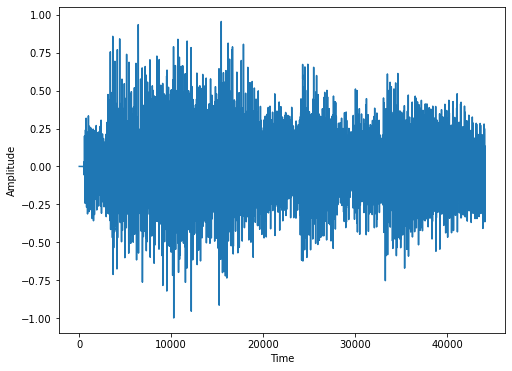

In [10]:
fig = plt.figure(figsize=(8,6))
plt.plot(x)
plt.xlabel("Time")
plt.ylabel("Amplitude");

Мы изобразили, как меняется амплитуда волны в зависимости от времени. Из школьного курса физики вы можете вспомнить, что может быть очень полезно смотреть и на частоты. Для этого воспользуемся дискретным косинусным преобразованием, из предыдущего раздела.

1. **(1 балл)** Используя `scipy.fft.dct` вычислите вектор частот $D_n x$, где $x$ - исходная дорожка. В каком промежутке сконцентрированы частоты?

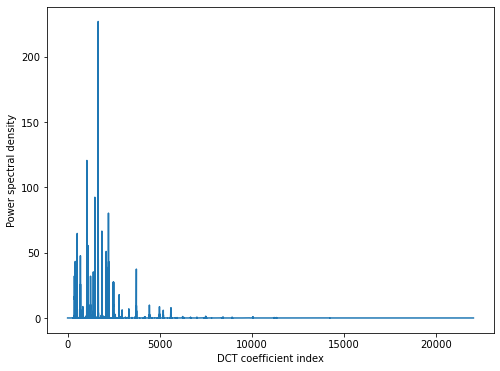

In [11]:
fig = plt.figure(figsize=(8,6))
dct_x = (scipy.fft.dct(x)).real
# Compute the PSD
psd = np.square(np.abs(dct_x)) / len(x)

# Plot the PSD
plt.plot(psd[:len(x)//2])
plt.xlabel('DCT coefficient index')
plt.ylabel('Power spectral density')
plt.show()

**Частоты сконцентрированы в промежутке от 0 до 5000 Герц**

В пункте (с) мы с использованием ДКП постараемся восстановить двухмерное изображение по значениям в небольшом числе пикселей. Чтобы облегчить решение двухмерной части мы сначала мотивируем действия на примере одномерной звуковой дорожки: будем хранить случайно выбранные 10% координат $w$, и обсудим, как по ним можно бы было восстановить исходную дорожку.

Говоря формально: построим матрицу $P \in \mathbb{R}^{m \times n}, m = \lfloor 0.1  n \rfloor$, причем в каждой строке и каждом столбце $P$ встречается ровно 1 единица, остальные значения равны 0. То есть $P$ - обрезанная матрица перестановки.

In [12]:
n = x.shape[0]
m = int(0.1 * n)
idxs = np.random.choice(n, m, replace=False)
P = np.zeros((m,n))
P[np.arange(m), idxs] = np.ones(m)
y = P @ x

Таким образом имеем:
\begin{align*}
    y = &Px\\
    s = &D_n x\\
    y = &PD_n^T s
\end{align*}

Можно как восстанавливать $x$ напрямую через $y$, так и решить сначала восстановить частоты $s$, а по ним однозначно получить $x$ через обратное ДКП.

2. **(2 балла)** Как известно, псевдообратная матрица даёт лучшее по 2 норме решение. Вычислите $x_{pinv}=P^{+}y$ за O(mn). Распишите координаты $x_{pinv}$ и объясните почему такое решение не помогает с восстановлением $x$.

**P.T удовлетворяет 4-м свойствам, которым удовлетворяет только псевдообратная матрица (лекция 8), значит, она и есть наша искомая.**

In [13]:
x_pinv = P.T @ y # P.T: n x m, y: m x 1 => умножение за O(mn)

**Ваше объяснение:**
$x_{pinv} = P^{+}y = V\Sigma^{+}U^Ty = V\Sigma^{+}U^TPx = V\Sigma^{+}U^TU\Sigma V^Tx = V\Sigma^{+}\Sigma V^Tx = V_rV^T_rx \neq x$

3. **(1 баллов)** Постройте график $D_nx_{pinv}$, сравните с графиком частот исходной волны. Чем они отличаются?

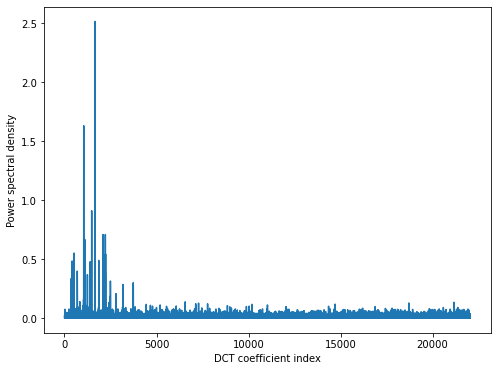

In [14]:
fig = plt.figure(figsize=(8,6))

dct_x_pinv = scipy.fft.dct(x_pinv)
# Compute the PSD
psd_pinv = np.square(np.abs(dct_x_pinv)) / len(x)

# Plot the PSD
plt.plot(psd_pinv[:len(x)//2])
plt.xlabel('DCT coefficient index')
plt.ylabel('Power spectral density')
plt.show()

**На данном графике сигналы на частотах наибольшей концентрации сильно слабее, чем на прошлом графике. Мы избавились от большого количества шума**

Теперь попробуем подойти к восстановлению изображения с другой стороны: будем решать при фиксированном $\mu > 0$ так называемую $\ell_2$-регуляризованную задачу наименьших квадратов (в англоязычной литературе ridge regression):

$$
\|Px - y\|_2^2 + \mu \|x\|_2^2 \to \min
$$

Смысл состоит в том, что мы хотим, чтобы одновременно и $x$ давала проекцию, похожую на $y$, и при этом сам вектор $x$ не был слишком велик по норме.

Для решения этой задачи запишем условие равенства нулю градиента этой функции:

$$
2(Px-y)^\top P + 2\mu x^\top = 0 \Leftrightarrow (P^\top P + \mu I)x = P^\top y.
$$


4. **(3 балла)** Объясните, почему в нашем случае не имеет смысла применять Ridge для восстановления исходного вектора (как решая относительно x, так и относительно s).

**Ваше решение:** 

*В обоих подходах только нулевой вектор удовлетворяет равенствам:*

$$(P^T P + \mu I)x = P^Ty \Leftrightarrow P^TPx + \mu Ix = P^TPx \Leftrightarrow \mu Ix = 0 \Leftrightarrow x = 0$$
$$(P^T P + \mu I)x = P^Ty \Leftrightarrow P^TPD^T_ns + \mu ID^T_ns = P^TPD^T_ns = 0\Leftrightarrow \mu ID^T_ns \Leftrightarrow s = 0$$

5. **(2 балла)** Вычислите матрицу $A = PD_n^T$ с помощью `scipy.fft.dct`. Не используйте транспонирование, ваш алгоритм должен быть сложности O(mn log n).

In [15]:
A = dct(P, axis = 0)
# A == dct(P.T).T

Интерпретация с частотами звуковой волной позволяет получить хорошую интуицию насчет ДКП: для массивов встречающихся в реальности вектор в пространстве частот будет близок к разреженному, то есть содержащему большое число нулей. В следующем разделе мы воспользуемся этим фактом для более умного метода восстановления входного массива, но на этот раз в двумерном случае.

### c. (16 баллов) Двумерный случай (изображение)

Рассмотрим [фотографию](https://en.wikipedia.org/wiki/Deconvolution) лунного кратера.

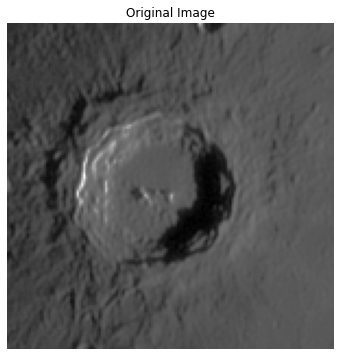

In [16]:
img = plt.imread("data/crater.png").astype(float)
X = img.mean(axis=2)
X -= X.mean()
X = X / np.abs(X).max()

plt.figure(figsize=(6,6))
plt.imshow(X, cmap="gray");
plt.axis("off")
plt.title("Original Image");

Занулим 80% всех пикселей.

In [17]:
n = X.shape[0]
m = int(0.2 * n*n)
idxs = np.random.choice(n*n, m, replace=False)

P = np.zeros((m,n*n))
P[np.arange(m), idxs] = np.ones(m)
y = P @ X.reshape(-1)

1. **(1 балл)** С помощью P постройте картинку исходного размера, где эти пиксели занулены:

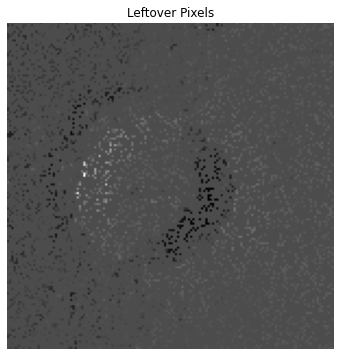

In [18]:
sparsed_X = (P.T @ y).reshape((n, n))

plt.figure(figsize=(6,6))
plt.imshow(sparsed_X, cmap="gray");
plt.axis("off")
plt.title("Leftover Pixels");

Если вы всё сделали правильно, то большяа часть картинки будет серой. Понятно, что по такому небольшому числу пискселей вряд ли получится восстановить детали изображения, но общие очертания мы получить все же сможем.

Для двумерных изображений нужно применять уже 2d дискретное косинусное преобразование (1d на векторизованной картинке потеряет вертикальную близость между пикселями -- можете попробовать).

Пусть $X \in \mathbb{R}^{n \times n}$ - исходное изображение. Тогда двумерным дискретным косинусным преобразованием будет:

$$
    S = D_n X D_n^T
$$

2. **(2 балла)** С помощью `scipy.fft.dct` постройте матрицу $S$ и изобразите её. Ваше решение должно быть сложности $O(n^2 \log n)$. Можно ли и в двумерном случае говорить о разреженности частот?

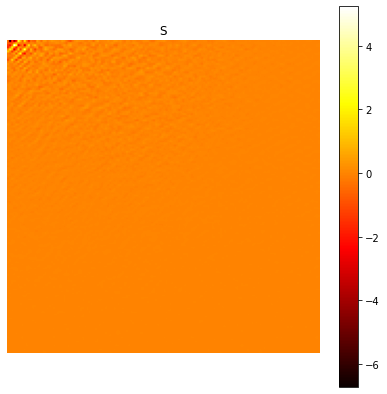

In [19]:
plt.figure(figsize=(7,7))
plt.axis("off")
S = dct(dct(X, axis=0, norm='ortho'), axis=1, norm='ortho')
plt.imshow(S, cmap="hot")
plt.colorbar()
plt.title("S");

То есть:

$$
    vec(S) = (D_n \otimes D_n) vec(X)
$$

Нам известно наблюдение $Y \in \mathbb{R}^{m \times m}$ с зануленными координатами:

$$
    vec(Y) = P vec(X)
$$

Выражение $Y$ через $S$ примет вид:

$$
    vec(Y) = \underbrace{P (D_n \otimes D_n)^{T}}_{A} vec(S)
$$

2. **(7 баллов)** Используя `scipy.fft.dct` и `scipy.fft.idct` постройте матрицу A. Ваше решение должно быть сложности $O(m^2n^2 \log n)$.

**Подсказка:** Для этого посмотрите как матрица $(D_n \otimes D_n)$ действует на каждую строку матрицы $P$ (или столбец матрицы $P^T$). Вам пригодится трехмерный `np.reshape`.

**Ваш вывод формулы:** 
$$vec(D_nWD_n^T) = (D_n \otimes D_n)vec(W) = (vec(W)^T(D_n \otimes D_n)^T)^T, P_i = vec(W) \Rightarrow$$
**Если матрицу Р развернуть в тензор, в котором каждый слой - развертка строки Р, то применив двумерное dct к каждому слою и свернув тензор обратно в матрицу, получим искомое. (Закомментированные строки - проверка)**

In [20]:
# ...
# Dn = dct(np.eye(n), axis=0, norm='ortho')
# DN = np.kron(Dn, Dn)
# res = P @ DN.T

P_n = P.T.reshape((n, n, m))
A = (dct(dct(P_n, axis = 1, norm='ortho'), axis = 0, norm='ortho')).reshape((n*n, m)).T

# np.allclose(A, res)

**Lasso**

Если в ridge regression вместо квадрата второй нормы $x$ использовать первую норму (то есть ставить $\ell_1$-регуляризованную задачу наименьших квадратов), то получится такая задача минимизации:
$$
\|Avec(S)-vec(Y)\|_2^2 + \mu \|vec(S)\|_1 \to \min.
$$

Такая задача оказывается более подходящей в нашем случае, так как её решение часто оказывается близким к разреженному (получить некоторую интуицию о том, почему так происходит, можно, например, [тут](https://medium.com/analytics-vidhya/intuition-behind-l1-l2-regularisation-2ac1e6a1bd81); более развёрнутое описание метода есть в [википедии](https://en.wikipedia.org/wiki/Lasso_(statistics))).

Однако разреженность исходной картинки $vec(X)$ вряд ли нам поможет. Вместо этого будем решать Lasso относительно $vec(S)$: ведь для частотного представления мы наблюдали разреженность.

5. **(6 баллов)** Заполните пропуски в функции *solve_lasso*. Примените её для решения $y = As$. По полученному решению восстановите вектор $x$ с помощью `scipy.fft.idct`. 

**Подсказка:** Воспользуйтесь [документацией sklearn.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)


In [21]:
from sklearn.linear_model import Lasso

def solve_lasso(A, y):
    lasso = Lasso(alpha=1e-6)
    lasso.fit(A, y)
    return lasso.coef_

In [22]:
vec_s = solve_lasso(A, y)
X_reconstructed = idct(vec_s).reshape((n, n))

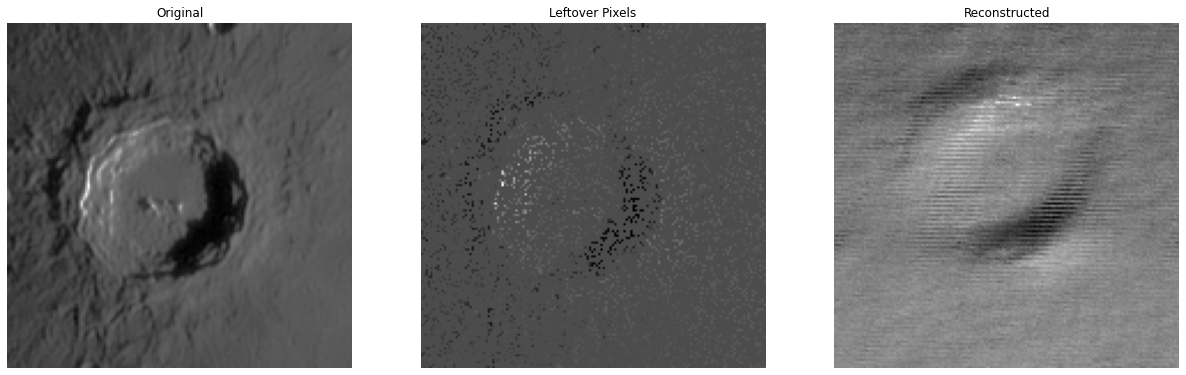

In [23]:
fig, axs = plt.subplots(figsize=(21, 7), ncols=3)
axs[0].imshow(X, cmap="gray")
axs[0].set(title="Original")
axs[0].axis("off")
axs[1].imshow((P.T @ y).reshape(n,n), cmap="gray")
axs[1].set(title="Leftover Pixels")
axs[1].axis("off")
axs[2].imshow(X_reconstructed, cmap="gray")
axs[2].set(title="Reconstructed")
axs[2].axis("off");

# Задача 2. Дискретная свертка и ее обращение (deconvolution) (50 баллов)

В этой задаче мы научимся эффективно вычислять **свёртку** изображения на примере одного из самых известных фильтров &mdash; фильтра Гаусса (подзадачи a., b., c.), а также попробуем восстановить исходное изображение из размытого (подзадача d.).

Начнем с эффективного применение фильтра Гаусса

Загрузим изображение (в виде матрицы $A$), с которым будем работать. Будем использовать одну из классических фотографий, применяемых для тестирования алгоритмов обработки изображений: "cameraman". 

(256, 256)


<ipython-input-24-d60419604d0e>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A = imread('data/cameraman.tif').astype(np.float)


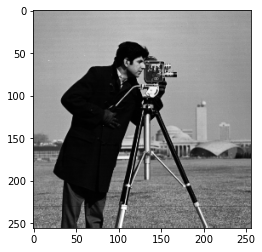

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

A = imread('data/cameraman.tif').astype(np.float)
print(A.shape)
_ = plt.imshow(A, cmap='gray')

Мы будем учиться применять к картинке [фильтр Гаусса](https://en.wikipedia.org/wiki/Gaussian_blur), чтобы получить в итоге что-то вроде следующего изображения. 

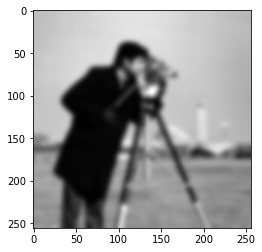

In [25]:
from scipy.ndimage import gaussian_filter
B = gaussian_filter(A, 3)
_ = plt.imshow(B, cmap='gray')

### a. (10 баллов) Формулировка задачи

При это преобразовании каждый пиксель картинки заменяется на взвешенную сумму соседних пикселей (вообще говоря, всех остальных пикселей картинки), причём вес пикселя со смещением $\Delta x$ и $\Delta y$ относительно данного есть
$$
G(\Delta x, \Delta y) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\Delta x^2 + \Delta y^2}{2\sigma^2}\right).
$$
Это называется двумерной **свёрткой** картинки с фильтром Гаусса (обычно при этом считается, что картинка продолжена за края каким-то образом, например, отражена, чтобы пиксели размытой картинки у краёв не имели меньшую яркость. Но мы не будем реализовывать этот эффект).

 1. **(10 баллов)** Покажите, что результат $B$ применения такой операции к матрице $A$ можно представить в виде
$$
    B = T_m A T_n^T,
$$
где 
$$
(T_n)_{i,j} = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(i-j)^2}{2\sigma^2}\right).
$$

**Замечание:** формулу для $B$ можно будет использовать в дальнейшем даже если этот пункт не был решен.


$$(T_mAT_n^T)_{ij} = \sum\limits_{k=1}^n(T_mA)_{ij}(T_n^T)_{kj}=\sum\limits_{k=1}^n\sum\limits_{l=1}^m(T_m)_{il}A_{lk}(T_n^T)_{kj}=$$
$$=\sum\limits_{k=1}^n\sum\limits_{l=1}^m(T_m)_{il}A_{lk}(T_n)_{kj} =$$
$$=\sum\limits_{k=1}^n\sum\limits_{l=1}^m \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(l-i)^2}{2\sigma^2}\right)A_{lk} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(k-j)^2}{2\sigma^2}\right)=$$ $$=\sum\limits_{k=1}^n\sum\limits_{l=1}^m A_{lk}\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(k-j)^2 + (l-i)^2}{2\sigma^2}\right) =$$
$$=\sum\limits_{k=1}^n\sum\limits_{l=1}^m A_{lk} G(\Delta x = (l-i), \Delta y = (k-j)) = B_{ij}$$

### b. (20 баллов) Имплементация одномерных сверток

1. **(12 баллов)** Реализуйте функцию `convolve_1D`, которая вычисляет $T_m A$ с помощью вложения $T_m$ в циркулянт и использования быстрого преобразования Фурье (```np.fft.fft```). Матрица $T_m$ задаётся с помощью своего первого столбца. При вычислениях нигде не должна возникнуть полная матрица $T_m$.

In [26]:
def convolve_1D(A, T_col):
    T_circ = np.concatenate((T_col, T_col[:0:-1]), axis=0)
    A_with_zeros = np.concatenate((A, np.zeros((A.shape[0] - 1, A.shape[1]))), axis=0) 
    res = np.fft.ifft((np.fft.fft(T_circ) * np.fft.fft(A_with_zeros, axis=0).T).T, axis=0)[:A.shape[0]]
    return res

Напишем также функцию `form_T_col`, которая будет создавать первый столбец матрицы `T_m` для заданных параметров `m` и `sigma`, а также `form_T`, которая будет создавать собственно матрицу $T_m$. Мы будем использовать `form_T` для тестирования правильности вычислений.

In [27]:
from scipy.linalg import toeplitz

def form_T_col(m, sigma):
    res = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp((-1 / sigma**2) * np.arange(m)**2)
    return res
    
def form_T(m, sigma):
    res = toeplitz(form_T_col(m, sigma))
    return res

Теперь мы можем проверить, правильно ли работает функция `convolve_1D`.

In [28]:
B = A[:5,:5]
sigma = 10
m, n = B.shape
T_m_col = form_T_col(m, sigma)
T_m = form_T(m, sigma)
np.linalg.norm(T_m @ B - convolve_1D(B, T_m_col))

2.2474722514611155e-14

2. **(2 балла)** Используя тот факт, что быстрое преобразование Фурье вектора длины $n$ вычисляется за $O(n\log n)$, выпишите асимптотику времени работы функции `convolve_1D`.


**Увеличить вектор до размера 2m-1 займет $O(m)$, добить A нулями займет $O(nm))$, вычисление np.fft.fft(T_circ) займет $O(m\log m)$ А для np.fft.fft(A_with_zeros) займет столько же, но для n столбцов $\Rightarrow$ $O(nm\log nm)$. Поэлементное умножение займет $O(nm)$.Применить обратное fft займет $O(nm\log m)$**

**Итоговая сложность: $O(mn \log(m))$**

3. **(5 балла)** Теперь нам понадобится функция `gauss_convolve_1D`, которая сформирует правильный столбец `T_col` и вызовет `convolve_1D`. Параметр `sigma` соответствует гауссовскому стандартному отклонению $\sigma$ из формулы для $G(\cdot)$.

In [29]:
def gauss_convolve_1D(A, sigma):
    T_col = form_T_col(A.shape[0], sigma)
    res = convolve_1D(A, T_col).real
    return res

4. **(1 балла)** Проверим, как работает наша одномерная свёртка на нашей картинке. Должно быть похоже, что каждый столбец размыли. Когда всё получится, попробуйте поиграть параметром `sigma` и объясните, как от него зависит "сила" размытия.

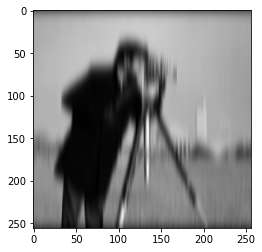

In [30]:
A_conv_1D = gauss_convolve_1D(A, 10)
_ = plt.imshow(A_conv_1D, cmap='gray')

**Размытие прямо пропорционально параметру sigma.**


### c. (8 баллов) Вычисление двумерной свертки

1. **(6 баллов)** Теперь вы уже без труда сможете написать функцию двумерной свёртки: $B = T_m A T_n^T$, используя функцию ```gauss_convolve_1D```.

In [31]:
def gauss_convolve_2D(A, sigma):
    return gauss_convolve_1D(gauss_convolve_1D(A, sigma).T, sigma).T

...и визуально проверить, правильно ли она работает.

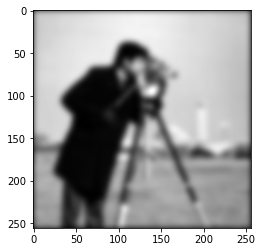

In [32]:
A_conv = gauss_convolve_2D(A, 5)
_ = plt.imshow(A_conv, cmap='gray')

2. **(2 балла)** Объясните эффект тёмных полос около края картинки.

**Темные полосы появляются из-за того, что мы дополняем нашу картинку нулями по краям, то есть размываем края черными пикселями**

### d. (12 баллов) Обращение свёртки (deconvolution)

Представьте, что к вам попало изображение такого типа.

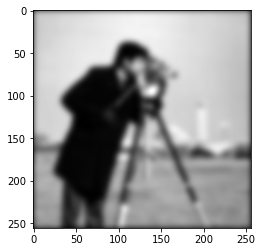

In [33]:
from scipy.ndimage import gaussian_filter
sigma = 5
A_conv = gauss_convolve_2D(A, sigma)
_ = plt.imshow(A_conv, cmap='gray')

Деталей не видно совсем. Чтобы восстановить их попробуем применить применить операцию обратную свертке. 
Мы уже знаем, что размытое изображение $A_{conv}$ вычисляется по формуле $A_{conv} = T_m A T_n^\top$.
Если же матрицы $T_m$ и $T_n$ обратимы, то можно обратить свёртку и получить обратно нашего cameraman:
$$
A = T_m^{-1} A_{conv} T_n^{-\top}.
$$

In [34]:
m, n = A_conv.shape
T_m, T_n = form_T(m, sigma), form_T(n, sigma)
B = np.linalg.solve(T_m, A_conv)
A_rec = np.linalg.solve(T_n, B.T).T

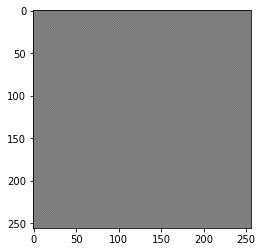

In [35]:
_ = plt.imshow(A_rec, cmap='gray')

Непохоже на исходное изображение. В чём может быть дело?
Давайте выведем сингулярные числа матрицы $G_m$.

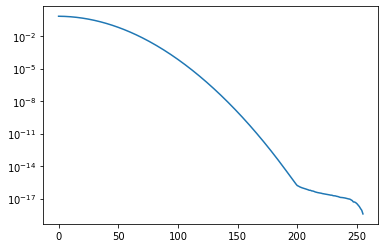

In [36]:
s = np.linalg.svd(T_m, compute_uv=False)
plt.plot(s)
_ = plt.semilogy()

Видно, что у нас большие проблемы (хотя пока мы не умеем это формализовывать), потому что матрица очень близка к вырожденной. Специально для таких матриц у нас есть инструмент псевдообратных матриц, но чтобы оправдать его применение, нужно сначала свести задачу вычисления матрицы $A$ к задаче решения системы линейных уравнений. 
Для этого вспомним формулу, связанную с Кронекеровым произведением: 
$$
\mathrm{vec}(A_{conv}) = (T_n \otimes T_m)\,\mathrm{vec}(A).
$$
Теперь уже можно вычислить "приближённый" $\mathrm{vec}(A)$ с помощью псевдообратных:
$$
\mathrm{vec}(\tilde{A}) = (T_n \otimes T_m)^+ \,\mathrm{vec}(A_{conv})
$$

Конечно, мы не хотим формировать матрицу размеров $mn \times mn$ и работать с ней, поэтому воспользуемся (проверьте) тем фактом, что
$$
(T_n \otimes T_m)^+ = T_n^+ \otimes T_m^+.
$$
Теперь можно перейти обратно к матричной записи: 
$$
\tilde{A} = T_m^+ A_{conv} (T_n^+)^\top.
$$

1. **(6 баллов)** Напишите функцию `pseudoinverse`, вычисляющую для заданной матрицы $P$ сингулярное разложение её $\delta$-псевдообратной.
Необходимо вернуть компактное SVD матрицы $P^+_\delta$.
Для вычисления используйте сингулярное разложение матрицы $P$. Использовать функцию `np.linalg.pinv` запрещено.

In [37]:
def pseudoinverse_svd(P, threshold=1e-15):
    u, s, vt = np.linalg.svd(P, full_matrices = False)
    
    s[s < threshold] = 0
    rank = np.count_nonzero(s)
    s_pinv = 1 / (s[:rank])
    res = vt.T[:, :rank], s_pinv, u.T[:rank, :]
    return res

Проверим, что псевдообратная совпадает с обратной для квадратной невырожденной матрицы $A$ (случайная матрица с вероятностью, очень близкой к единице, является невырожденной).

In [38]:
a = np.random.random((3, 3)) # заменила А на а, потому что перекрывает А, которая отвечает за картинку (первая ячейка во 2 части ноутбука)
u, s, vt = pseudoinverse_svd(a)
pinv = np.multiply(u, s) @ vt
assert np.linalg.norm(pinv @ a - np.eye(3)) < 1e-12

2. **(6 баллов)** Реализуйте функцию ```inverse_gauss_convolve_2D```, которая реконструирует изображение по "смазанной" картинке $A_{conv}$ с помощью псевдообратных матриц от матриц $T_m$ и $T_n$, у которых занулили сингулярные числа меньше ```tol```. **Замечание:** В данном случае ```np.linalg.pinv``` выдаст всю псевдообратную матрицу, что подойдет в качестве решения. Но можно сделать немного эффективнее, если явно умножать на компоненты компактного SVD.

In [39]:
def inverse_gauss_convolve_2D(A_conv, sigma, tol):
    m, n = A_conv.shape
    T_n = form_T(n, sigma)
    T_m = form_T(m, sigma)
    vn, snt, utn = pseudoinverse_svd(T_n.T, tol)
    vm, sm, utm = pseudoinverse_svd(T_m, tol)
    return vn @ np.diag(snt) @ utn @ A_conv @ vm @ np.diag(sm) @ utm

Посмотрим на получившийся результат.

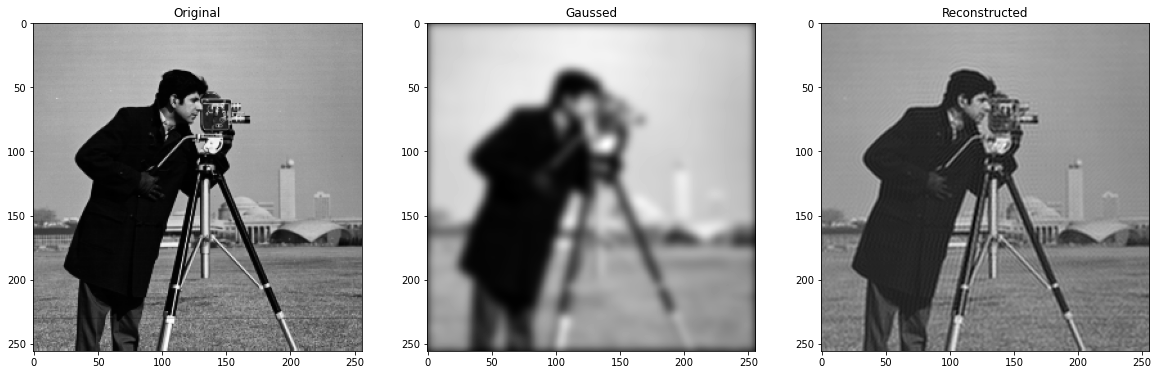

In [40]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(A, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(A_conv, cmap='gray')
axs[1].set_title("Gaussed")
A_rec = inverse_gauss_convolve_2D(A_conv, sigma, 1e-8)
axs[2].imshow(A_rec, cmap='gray')
_ = axs[2].set_title("Reconstructed")

## Бонус

Выберем 
$$
\tilde G(\Delta x, \Delta y) = C(\alpha) \exp\left(-\alpha\sqrt{\Delta x^2 + \Delta y^2}\right),
$$
где $C(\alpha)$ выбирается из $\ell_1$ нормировки массива (допускается найти $C(\alpha)$ численно).

1. **(60 б. баллов)** С помощью вложения БТТБ в БЦЦБ матрицу $C$ реализуйте двумерную свертку с картинкой из предыдущей задачи и с фунцией $\tilde G$ вместо $G$. Постройте свертку для разных значений параметра $\alpha$ и опишите наблюдаемые эффекты.


2. **(40 б. баллов)** Используя $C$ из предыдущего бонусного пункта, дополните картинку нулями до подходящего размера, посчитайте свертку, а затем обратите ее с помощью применения $\delta$-псевдообратной. Требуемая сложность: $\mathcal{O}(mn \log mn)$ для $m\times n$ картинки. Постройте свертку для разных значений параметров $\alpha$ и $\delta$ и опишите наблюдаемые эффекты.